## Create Environment and Set up Simulation 

In [ ]:
# iPython extension to autoreload modules when changes without restarting kernel
%load_ext autoreload
%autoreload 2

from functions.simulation_setup import set_schema_buildings, set_active_observations, set_schema_simulation_period
from citylearn.data import DataSet


print('All CityLearn datasets:', sorted(DataSet().get_dataset_names()))
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet().get_schema(DATASET_NAME)

RANDOM_SEED = 0
BUILDING_COUNT = 2
DAY_COUNT = 7
ACTIVE_OBSERVATIONS = ['hour', 'month', 'indoor_dry_bulb_temperature']

schema, buildings = set_schema_buildings(schema, BUILDING_COUNT, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, DAY_COUNT, RANDOM_SEED)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)
schema['central_agent'] = True


print('Selected buildings:', buildings)
print(
    f'Selected {DAY_COUNT}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All CityLearn datasets: ['baeda_3dem', 'ca_alameda_county_neighborhood', 'citylearn_challenge_2020_climate_zone_1', 'citylearn_challenge_2020_climate_zone_2', 'citylearn_challenge_2020_climate_zone_3', 'citylearn_challenge_2020_climate_zone_4', 'citylearn_challenge_2021', 'citylearn_challenge_2022_phase_1', 'citylearn_challenge_2022_phase_2', 'citylearn_challenge_2022_phase_3', 'citylearn_challenge_2022_phase_all', 'citylearn_challenge_2022_phase_all_plus_evs', 'citylearn_challenge_2023_phase_1', 'citylearn_challenge_2023_phase_2_local_evaluation', 'citylearn_challenge_2023_phase_2_online_evaluation_1', 'citylearn_challenge_2023_phase_2_online_evaluation_2', 'citylearn_challenge_2023_phase_2_online_evaluation_3', 'citylearn_challenge_2023_phase_3_1', 'citylearn_challenge_2023_phase_3_2', 'citylearn_challenge_2023_phase_3_3', 'quebec_neighborhood_with_demand_response_set_points', 'quebec_neighborhood

## Base Agent

In [20]:
from agents.baseagent import Agent
from citylearn.citylearn import CityLearnEnv

base_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
base_agent = Agent(base_env, random_seed=RANDOM_SEED)

# Initialize Environment
observations, _ = base_env.reset()

while not base_env.terminated:
    actions = base_agent.predict(observations)
    observations, reward, info, terminated, truncated = base_env.step(actions)

# test
kpis = base_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,1.839
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,2.159,2.565,2.362
cost_total,2.308,2.564,2.436
daily_one_minus_load_factor_average,NaN,NaN,0.929
daily_peak_average,NaN,NaN,2.112
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


In [3]:
# A general environment with discrete observations and actions that can be re-used for multiple agent types
from functions.wrappers import DiscreteAlgorithmWrapper

discrete_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)

# define active observations and actions and their bin sizes
observation_bins = {'hour': 24, 'month':12, 'electricity_pricing':15}
action_bins = {'electrical_storage': 12, 'heating_storage': 12}

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in discrete_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)




## Q Learning Agent

Sampling based on CityLearn Implementation to create framework for how we will test and implement our new algorithms

In [4]:
from agents.qlearning import TabularQLearning

# This made for Tabular Q learning, but I think it applies to any discrete algorithm
q_env = DiscreteAlgorithmWrapper(
    discrete_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

q_kwargs = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

q_agent = TabularQLearning(
    env=q_env,
    random_seed=RANDOM_SEED,
    **q_kwargs
)

# Initialize Environment
observations, _ = q_env.reset()

while not q_env.terminated:
    actions = q_agent.predict(observations)
    observations, reward, info, terminated, truncated = q_env.step(actions)

# test
kpis = q_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymn

name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,2.094
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,2.267,2.709,2.488
cost_total,2.259,2.394,2.326
daily_one_minus_load_factor_average,NaN,NaN,0.933
daily_peak_average,NaN,NaN,2.247
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


## Sarsa

In [8]:
from agents.sarsa import Sarsa

sarsa_env = DiscreteAlgorithmWrapper(
    discrete_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

sarsa_kwargs = {
    'epsilon': 0.1,
    'alpha': 0.005,
    'gamma': 0.99,
}

sarsa_agent = Sarsa(
    env=sarsa_env,
    random_seed=RANDOM_SEED,
    **sarsa_kwargs
)

# Initialize Environment
observations, _ = sarsa_env.reset()

while not sarsa_env.terminated:
    actions = sarsa_agent.predict(observations)
    observations, reward, info, terminated, truncated = sarsa_env.step(actions)

# test
kpis = sarsa_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymn

name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,2.194
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,2.377,2.279,2.328
cost_total,2.328,2.154,2.241
daily_one_minus_load_factor_average,NaN,NaN,0.945
daily_peak_average,NaN,NaN,2.471
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


## Compare the Models

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


Building-level KPIs:


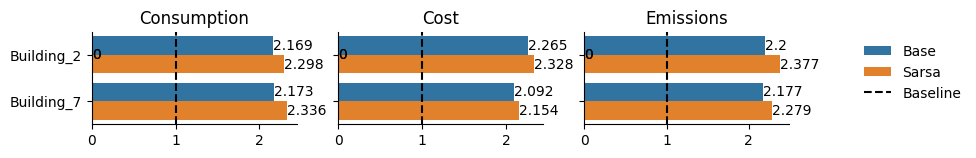

Building-level load profiles:


/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


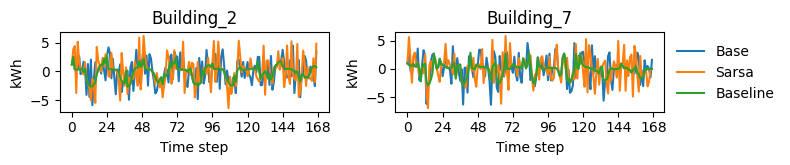

Battery SoC profiles:


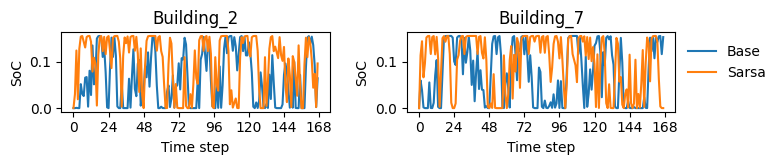

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


District-level KPIs:


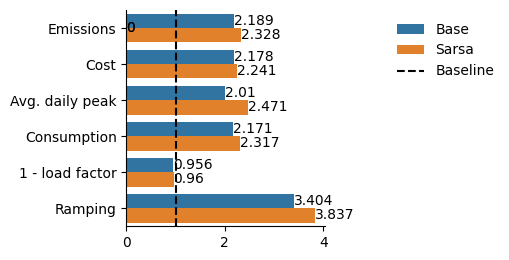

District-level load profiles:


/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.net_electricity_consumption to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption` for environment variables or `env.get_wrapper_attr('net_electricity_consumption')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.net_electricity_consumption_without_storage to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption_without_storage` for environment variables or `env.get_wrapper_attr('net_electricity_consumption_without_storage')` that will search the reminding wrappers.
  l

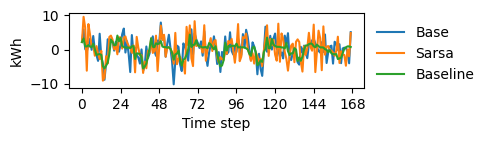

In [10]:
from functions.make_figures import plot_simulation_summary

plot_simulation_summary({'Base': base_env, 'Sarsa': sarsa_env})